In [1]:
from pmdarima import auto_arima
import warnings
import prediction_plots_final as pplot
import functions as f
import data_testing as dt
import data_prep as d
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In order to determine whether DC Bikeshare has a sufficient number of bicycles in stock for the upcoming 12 months, we obtained data on the number of times per month that customers have checked bicycles out between September, 2010 and July, 2019. We obtained this data from https://s3.amazonaws.com/capitalbikeshare-data/index.html. Although the data is originally in daily form, we have grouped the data by month in order to remove excessive day-by-day variations within the timeframe.

First, we will download the cleaned dataset. If you have the relevant raw datasets, you can also create a cleaned dataset with d.full_clean().

In [2]:
bike_df = f.import_cleaned()

In [3]:
bike_df.head()

count
date_of_trip       
2010-09-30     4002
2010-10-31    35957
2010-11-30    47390
2010-12-31    28248
2011-01-31    37503

Now, we will plot an initial timeseries graph to ensure that the data is functional.

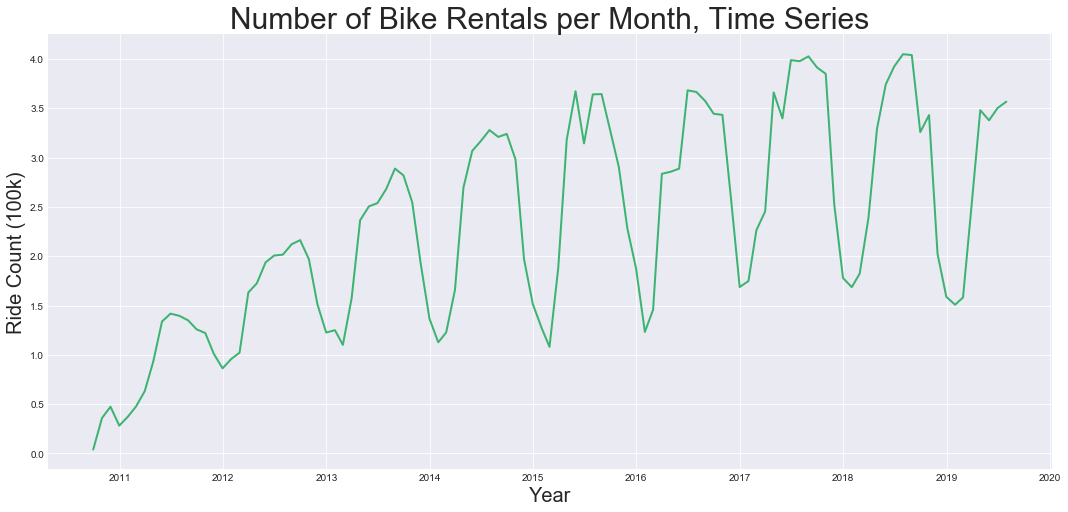

In [5]:
pplot.initial_plot(bike_df)

Before moving forward, we will divide the data into a 75% training data set and a 25% testing data set. We will then graph both to make sure that the split is functional.

In [6]:
train_df, test_df = f.train_split(bike_df)

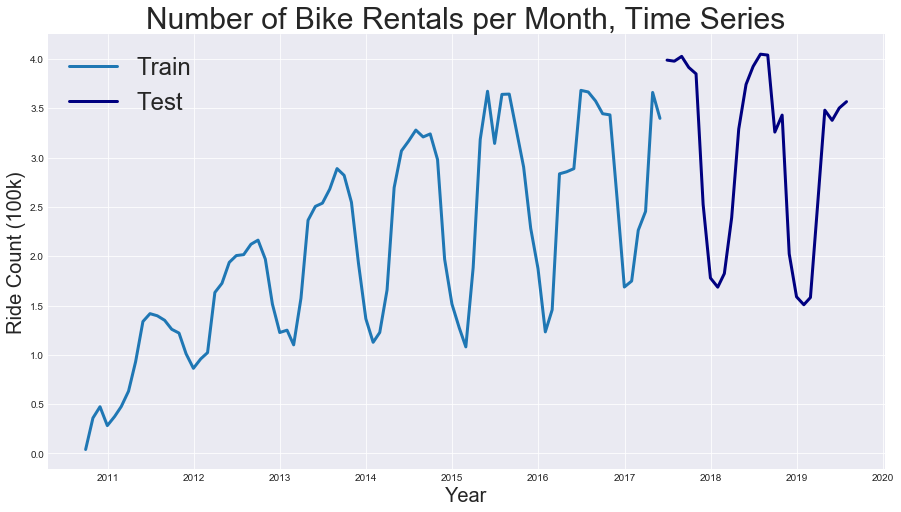

In [7]:
pplot.split_plot(train_df, test_df)

In order to determine whether there is either a trend or a seasonal fluctuation, we will create a decomposition.

<Figure size 432x288 with 0 Axes>

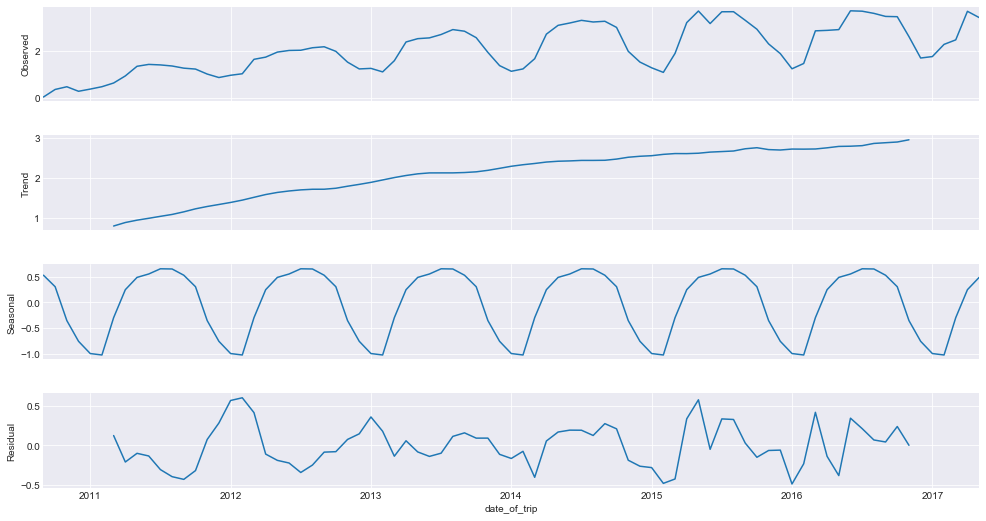

In [8]:
pplot.decomposition(train_df)

In order to test the stationarity of the timeseries, we will plot the rolling statistics and perform a Dickey-Fuller test on the original data, the first difference, the second difference, the seasonal difference of the original data, and the seasonal difference of the first difference. This is done to determine the number of regular and seasonal differences we will use in our predictive model.

We will also create autocorrelations and partial autocorrelations for each difference, for later use in determining the number of auto-regressive and moving-average terms to add to our prediction model.

## Original 

The purpose of this test is to determine the stationarity and autocorrelarity
 of the original timeseries.


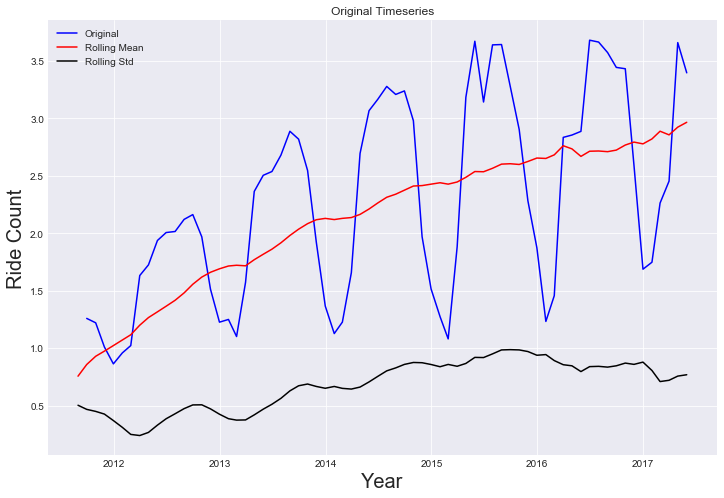

Results of Dickey-Fuller Test:
Test Statistic                 -4.065344
p-value                         0.001104
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


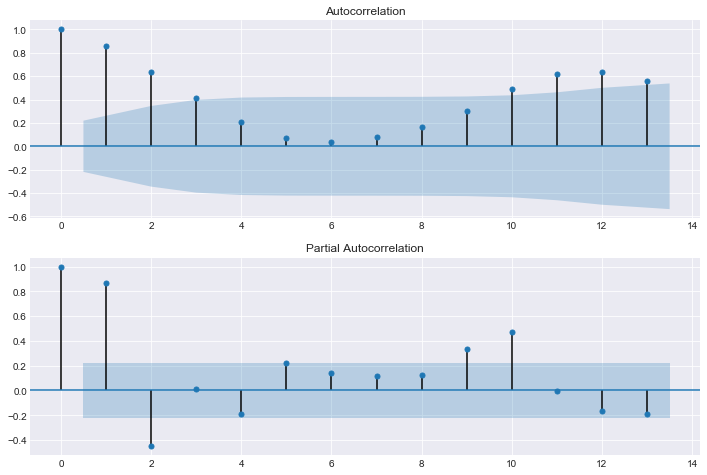

In [9]:
dt.stationarity_autocorrelation_test_original(train_df)

## First Order Difference

The purpose of this test is to determine the stationarity and autocorrelarity
 of the first difference.


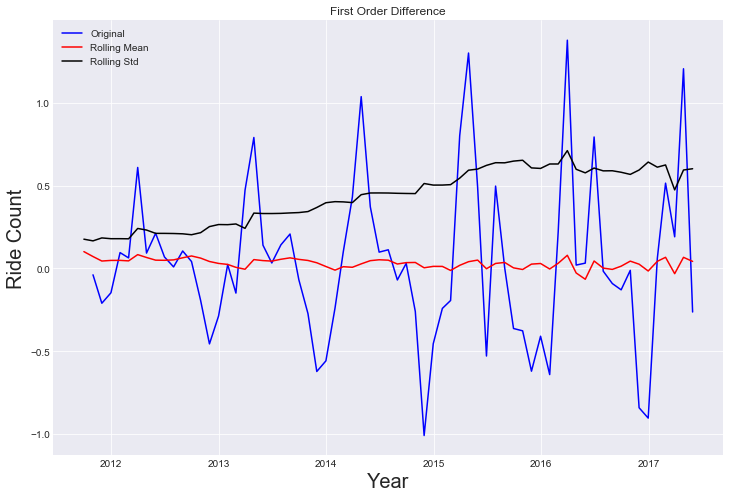

Results of Dickey-Fuller Test:
Test Statistic                 -3.316431
p-value                         0.014160
#Lags Used                     12.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


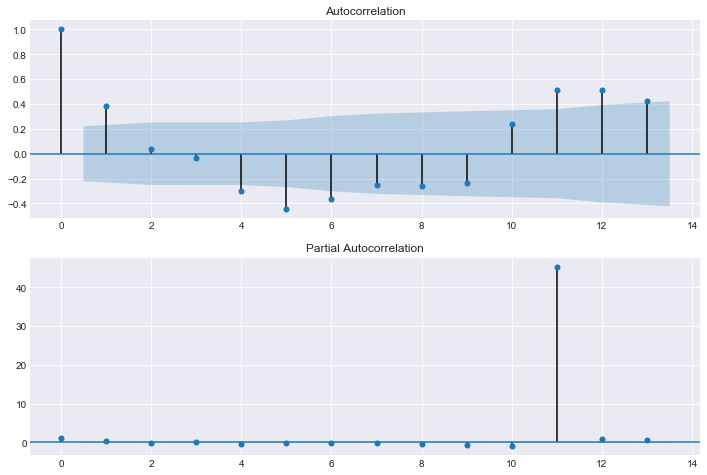

In [9]:
dt.stationarity_autocorrelation_test_first_diff(train_df)

## Second Order Difference 

The purpose of this test is to determine the stationarity and autocorrelarity
 of the second difference.


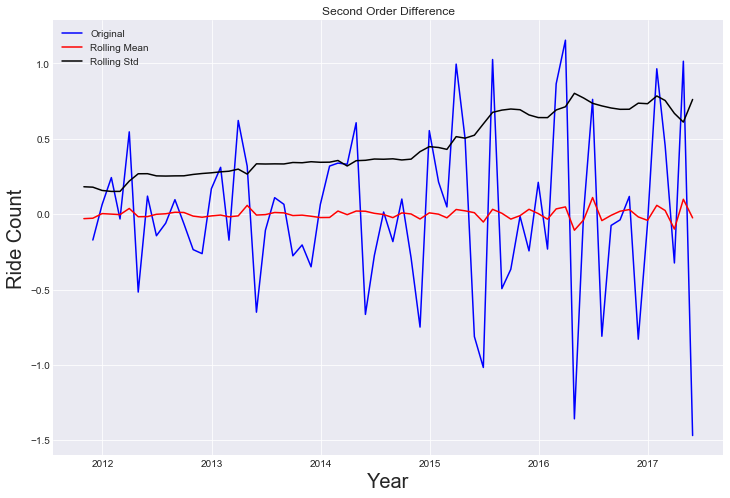

Results of Dickey-Fuller Test:
Test Statistic                -8.753455e+00
p-value                        2.796057e-14
#Lags Used                     1.100000e+01
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


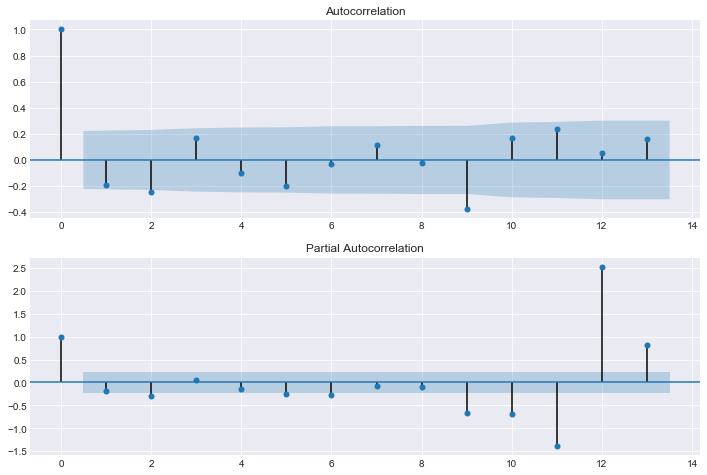

In [10]:
dt.stationarity_autocorrelation_test_second_diff(train_df)

Although the original graph has a low p-value, the graph suggests that the timeseries's mean is not stationary. However, both the first and second orders seem stationary, and there is less than a 2% probability that either is not stationary, according to the p-value. As such, we will either have the non-seasonal data have 1 or 2 differences, depending, on whether the seasonal variability requires a difference.

## First Seasonal Difference 

The purpose of this test is to determine the stationarity and autocorrelarity
 of the seasonal difference.


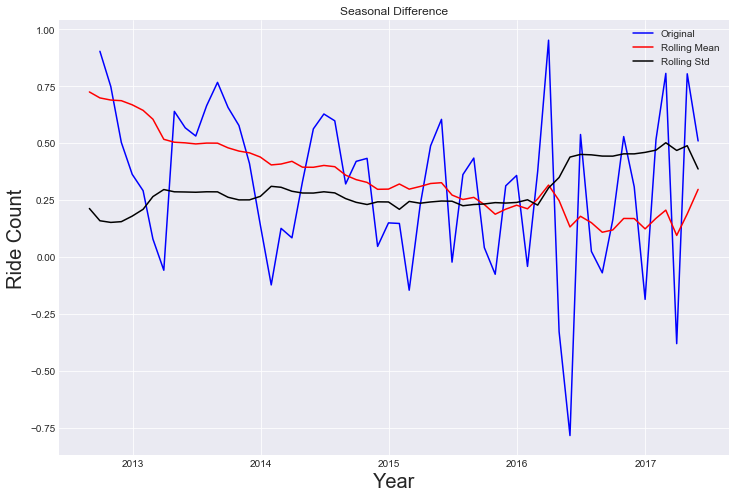

Results of Dickey-Fuller Test:
Test Statistic                 -1.953684
p-value                         0.307243
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


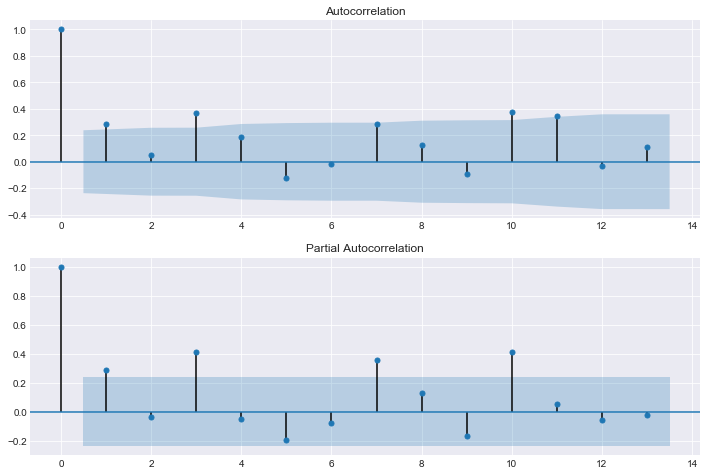

In [10]:
dt.stationarity_test_seasonal_diff(train_df)

## First Seasonal Difference of First Order Difference

The purpose of this test is to determine the stationarity and autocorrelarity
 of the seasonal difference of the first difference.


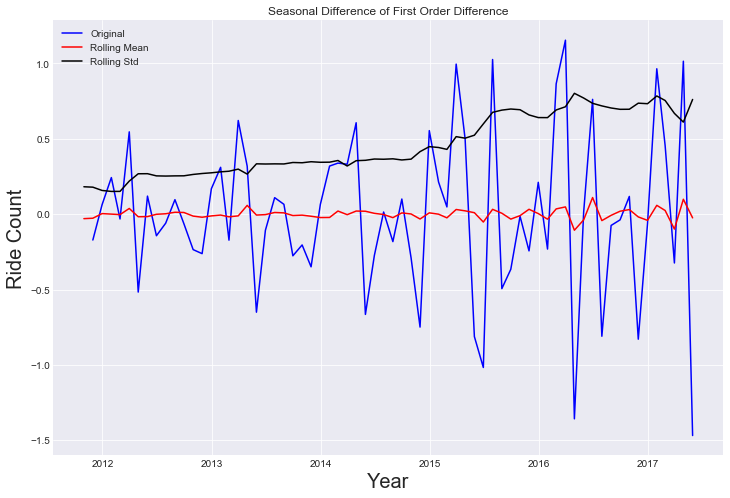

Results of Dickey-Fuller Test:
Test Statistic                -8.753455e+00
p-value                        2.796057e-14
#Lags Used                     1.100000e+01
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


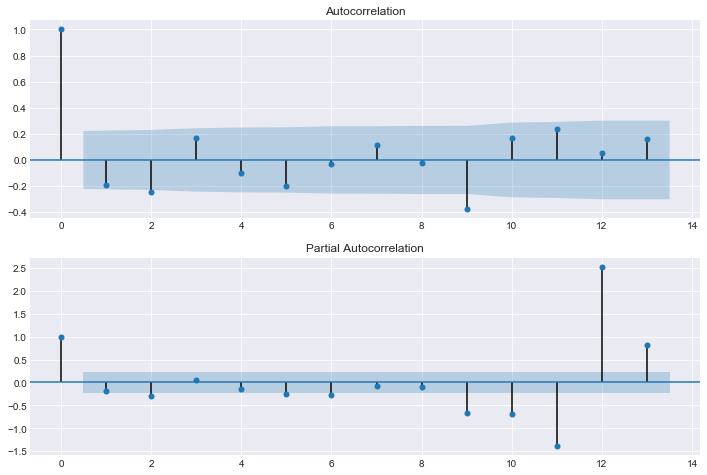

In [11]:
dt.stationarity_test_seasonal_first_diff(train_df)

The seasonal difference of the original dataset does not seem to have a stationary mean, and the p-value of the Dickey-Fuller tests is much larger than .05, we can assume that it is not stationary. However, the seasonal regression of the first order difference looks stationary, and the Dickey-Fuller p-value is less than .05, this indicates that we should use one seasonal difference. Since we are using one seasonal difference, we should only use one regular difference in our model as well, in order to avoid overfitting.

Since the partial autocorrelation of the first difference seems positive, it suggests we will need two AR terms, while the ACF suggests between 1 and 3 MA terms. The seasonal difference of the first difference PACF suggests that it will probably have no AR terms, and 1 MA term. The seasonal lag should be 12 months.

To make sure that this is correct, we will run Sarima tests on all potential models with a p level of 2, a d level of 1, a D level of 1, and a 12-month seasonal cycle, on both our training and test data.

The purpose of this test is to determine the model with the best fit
 using Sarima.
                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -803.368
Date:                            Fri, 13 Sep 2019   AIC                           1612.736
Time:                                    20:48:28   BIC                           1619.394
Sample:                                09-30-2010   HQIC                          1615.374
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4843      0.0

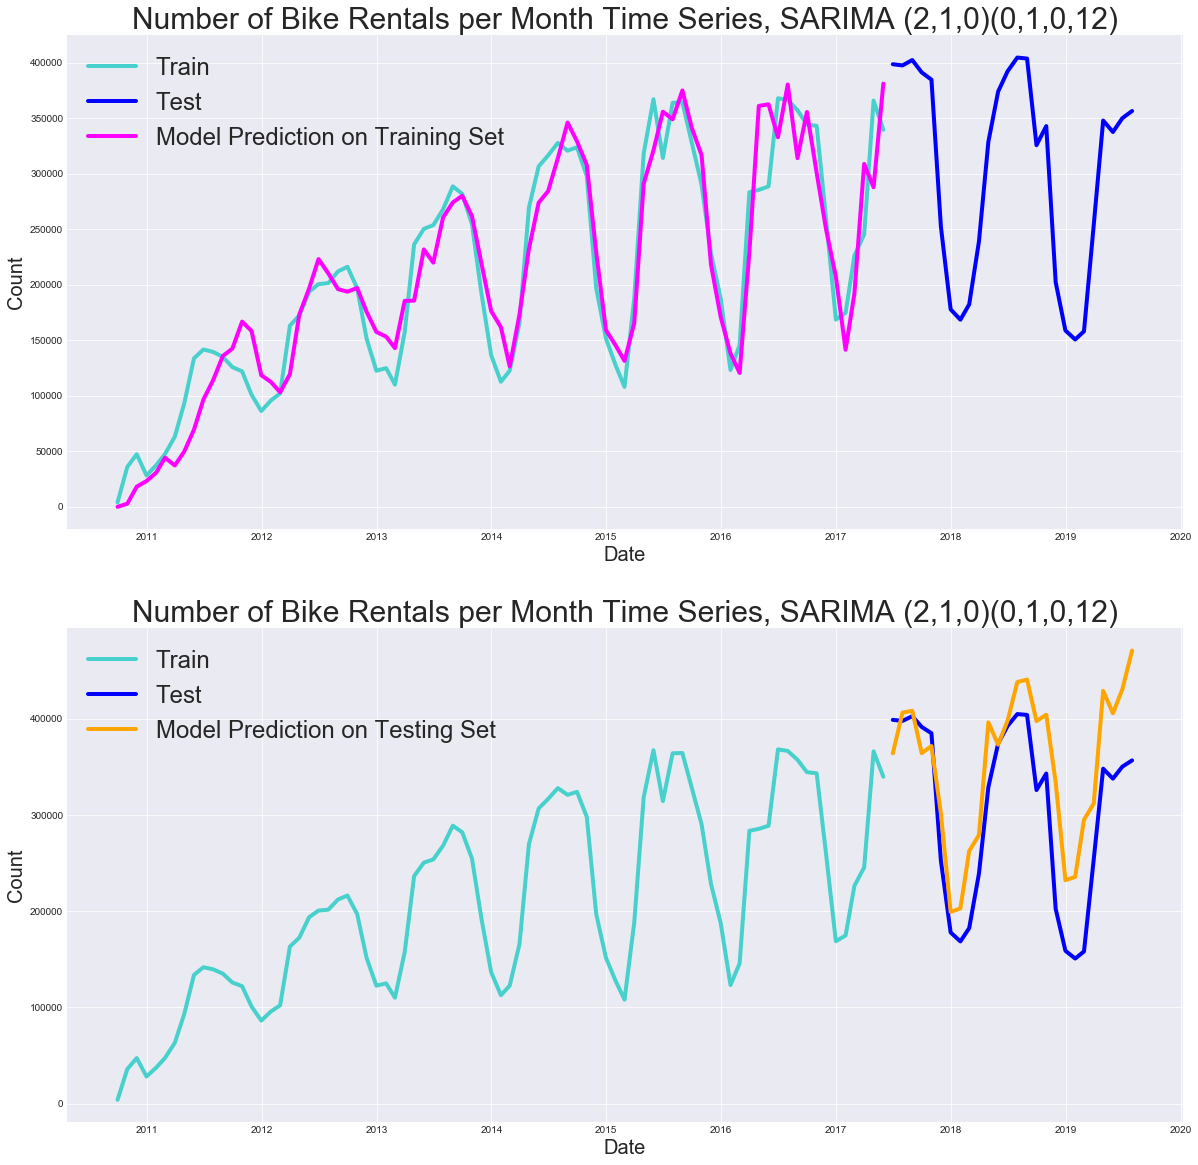

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -802.946
Date:                            Fri, 13 Sep 2019   AIC                           1613.891
Time:                                    20:48:34   BIC                           1622.769
Sample:                                09-30-2010   HQIC                          1617.409
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4403      0.080     -5.496      0.000      -0.597      -0.283
ar.L2         -0.5177      0.102   

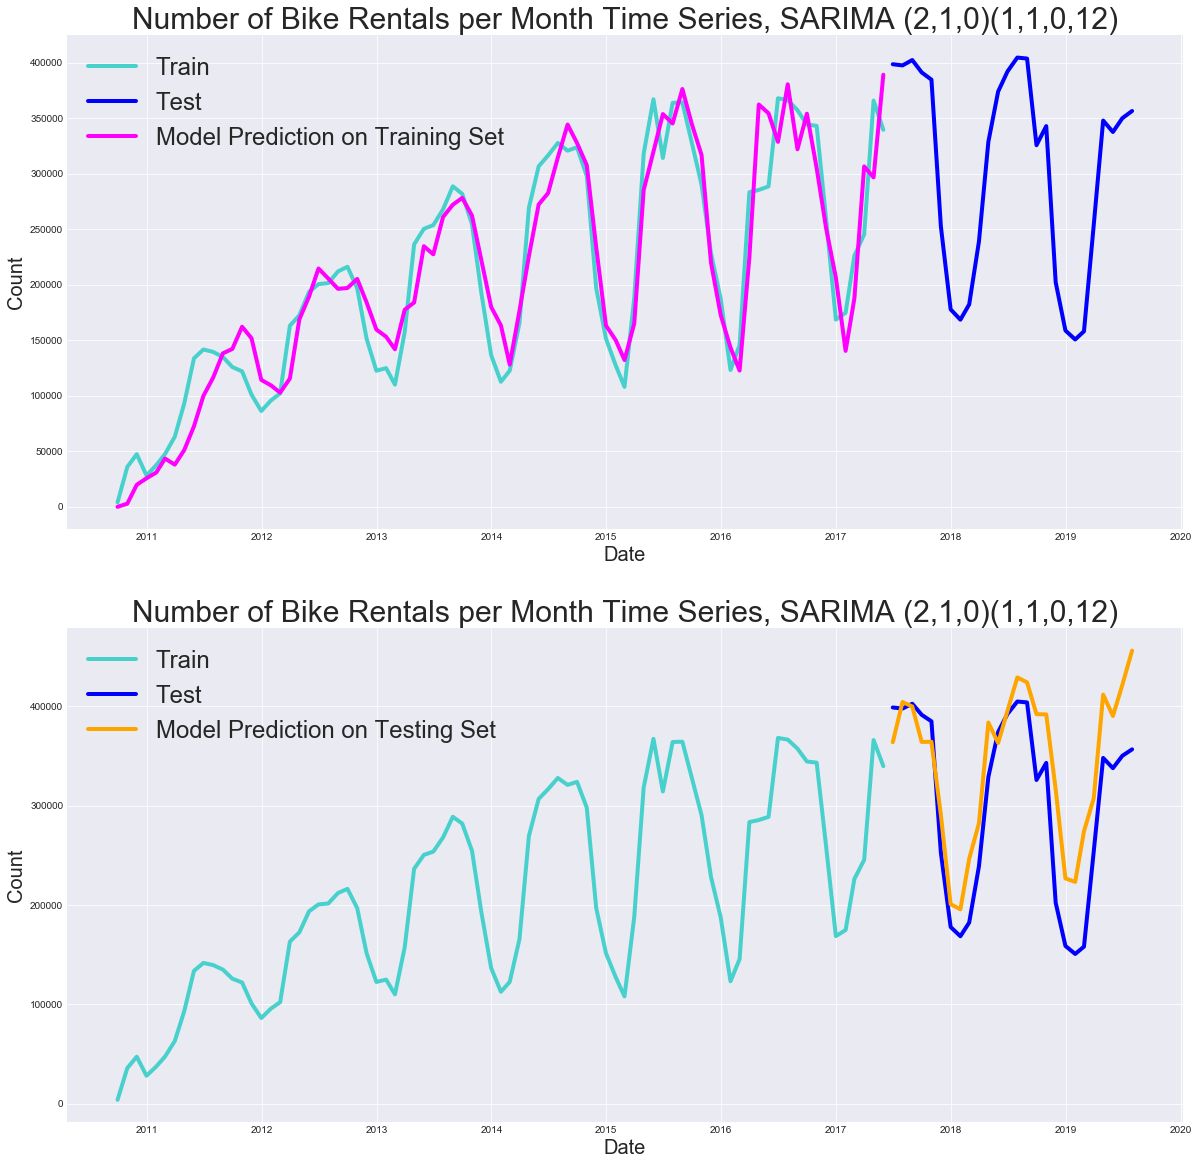

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -812.543
Date:                            Fri, 13 Sep 2019   AIC                           1633.086
Time:                                    20:48:38   BIC                           1641.964
Sample:                                09-30-2010   HQIC                          1636.604
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0780      0.101      0.771      0.441      -0.120       0.276
ar.L2         -0.1748      0.111   

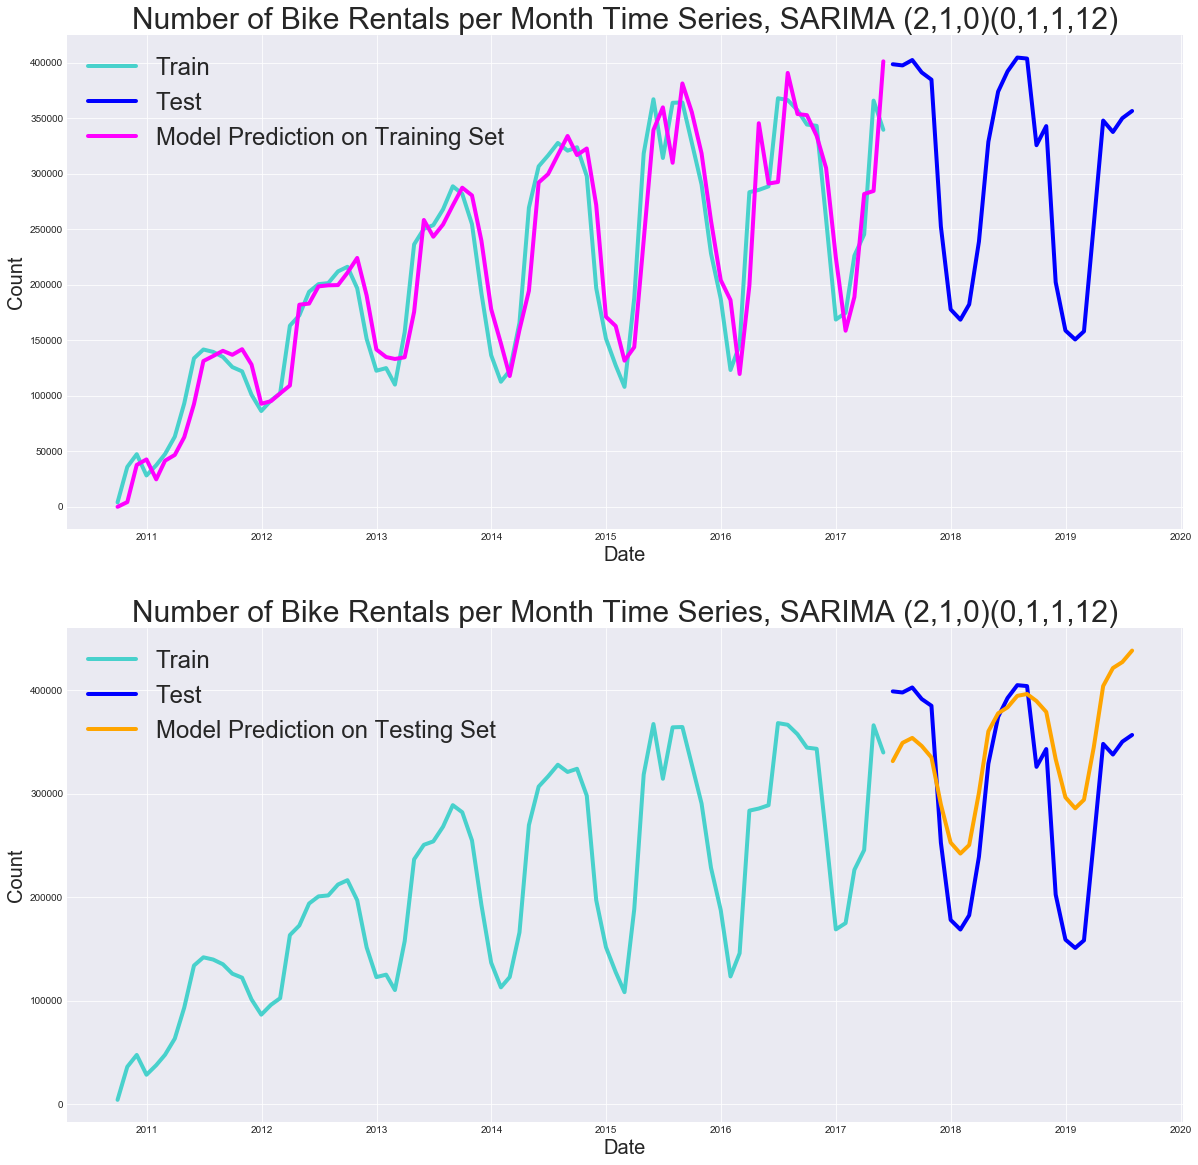

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -803.140
Date:                            Fri, 13 Sep 2019   AIC                           1614.279
Time:                                    20:48:42   BIC                           1623.157
Sample:                                09-30-2010   HQIC                          1617.797
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5792      0.196     -2.959      0.003      -0.963      -0.196
ar.L2         -0.6246      0.107   

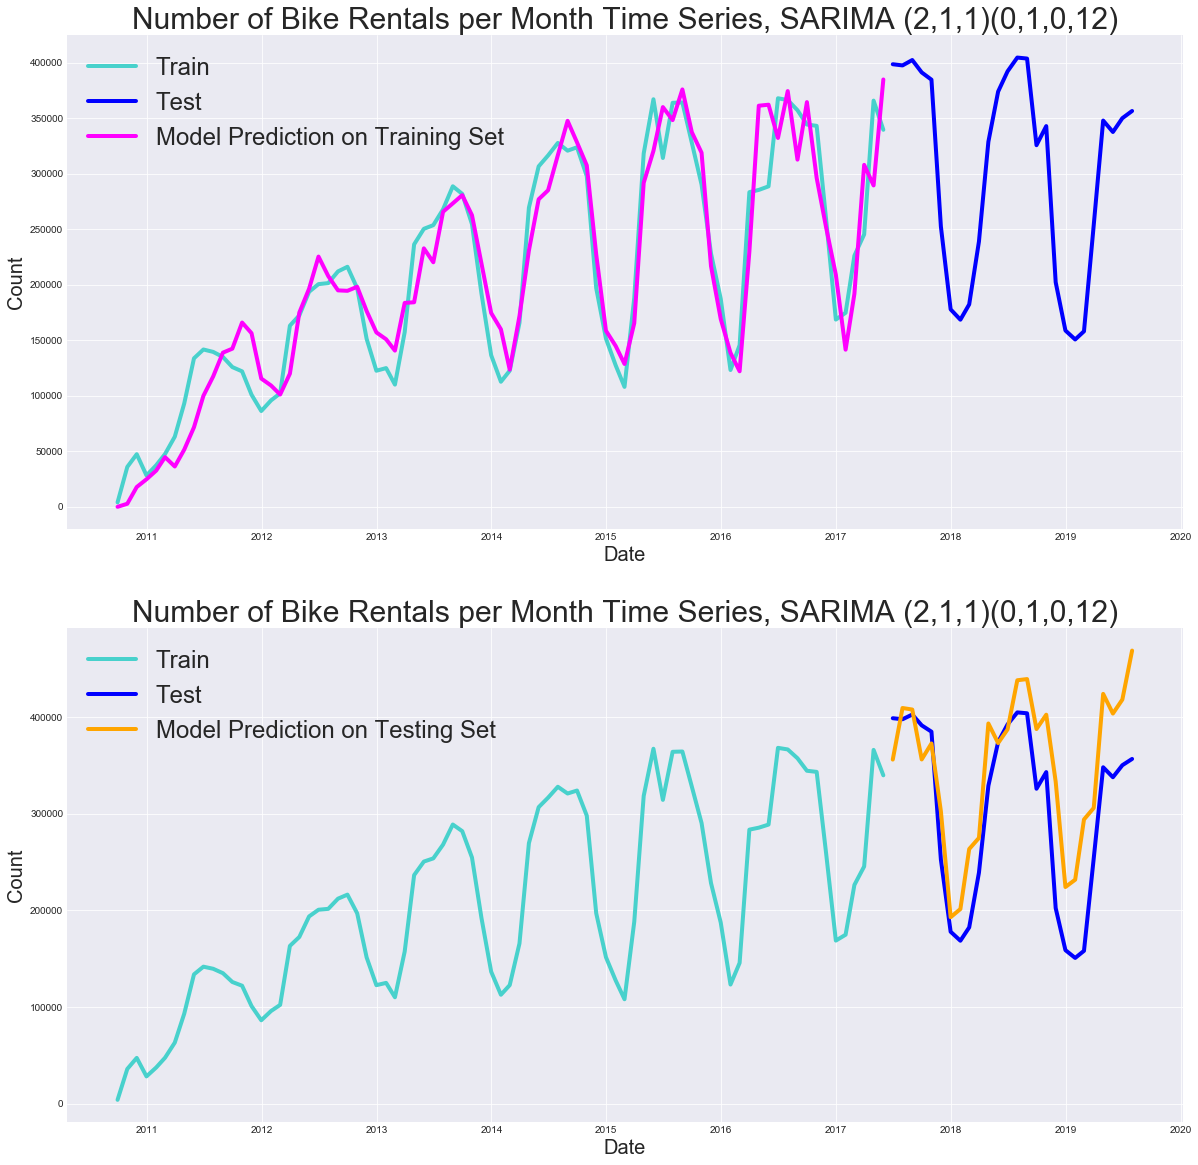

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -802.543
Date:                            Fri, 13 Sep 2019   AIC                           1615.087
Time:                                    20:48:48   BIC                           1626.184
Sample:                                09-30-2010   HQIC                          1619.484
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5969      0.248     -2.410      0.016      -1.082      -0.111
ar.L2         -0.5633      0.129   

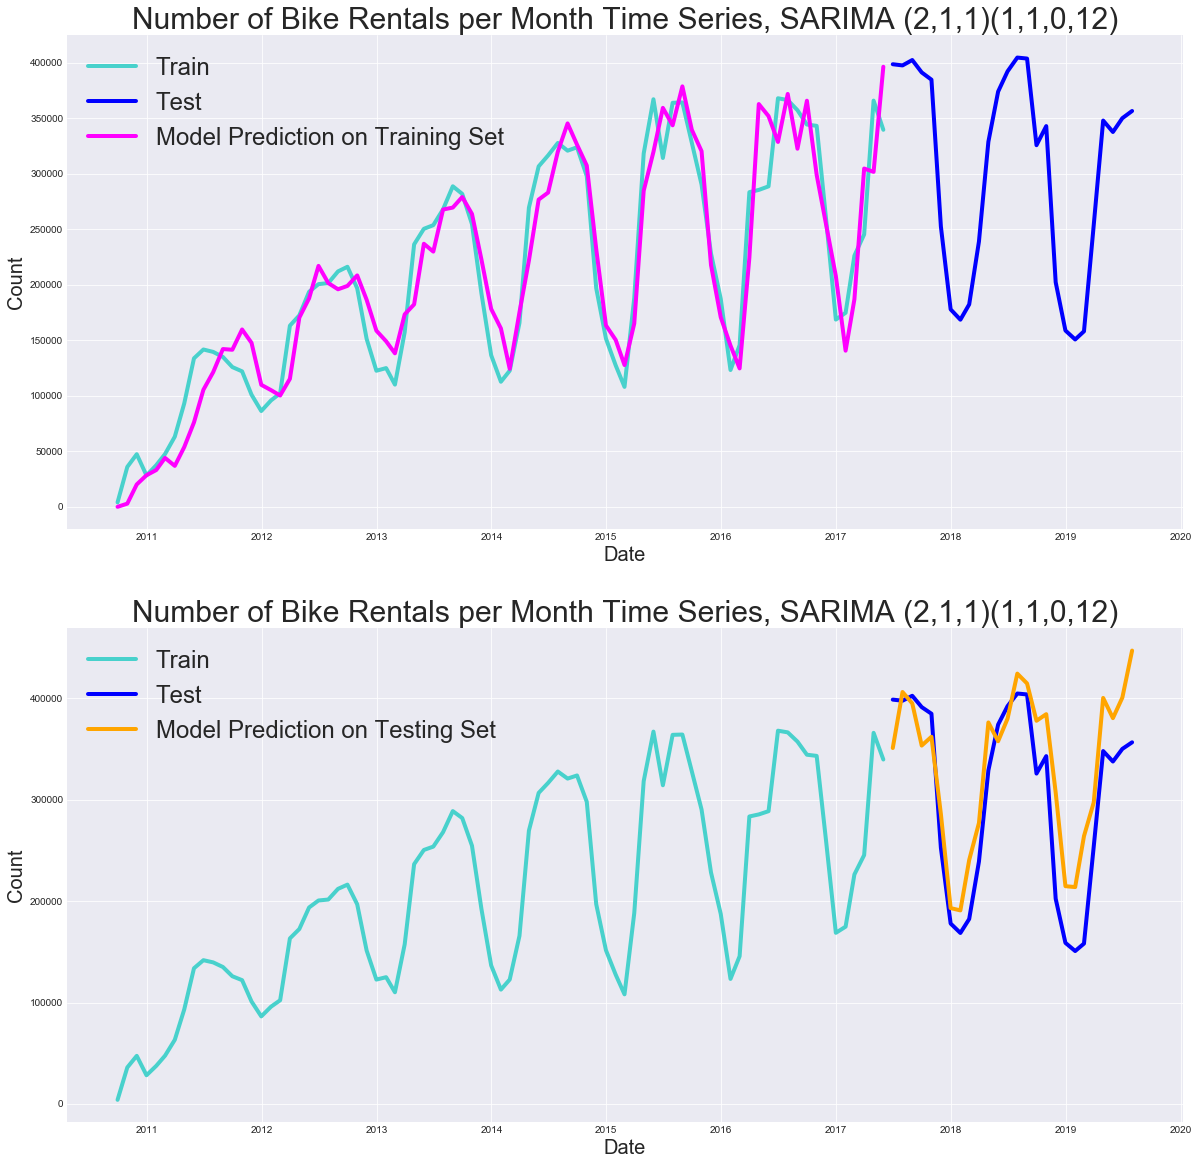

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -811.222
Date:                            Fri, 13 Sep 2019   AIC                           1632.443
Time:                                    20:48:54   BIC                           1643.541
Sample:                                09-30-2010   HQIC                          1636.841
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4805      0.396     -1.213      0.225      -1.257       0.296
ar.L2         -0.1940      0.149   

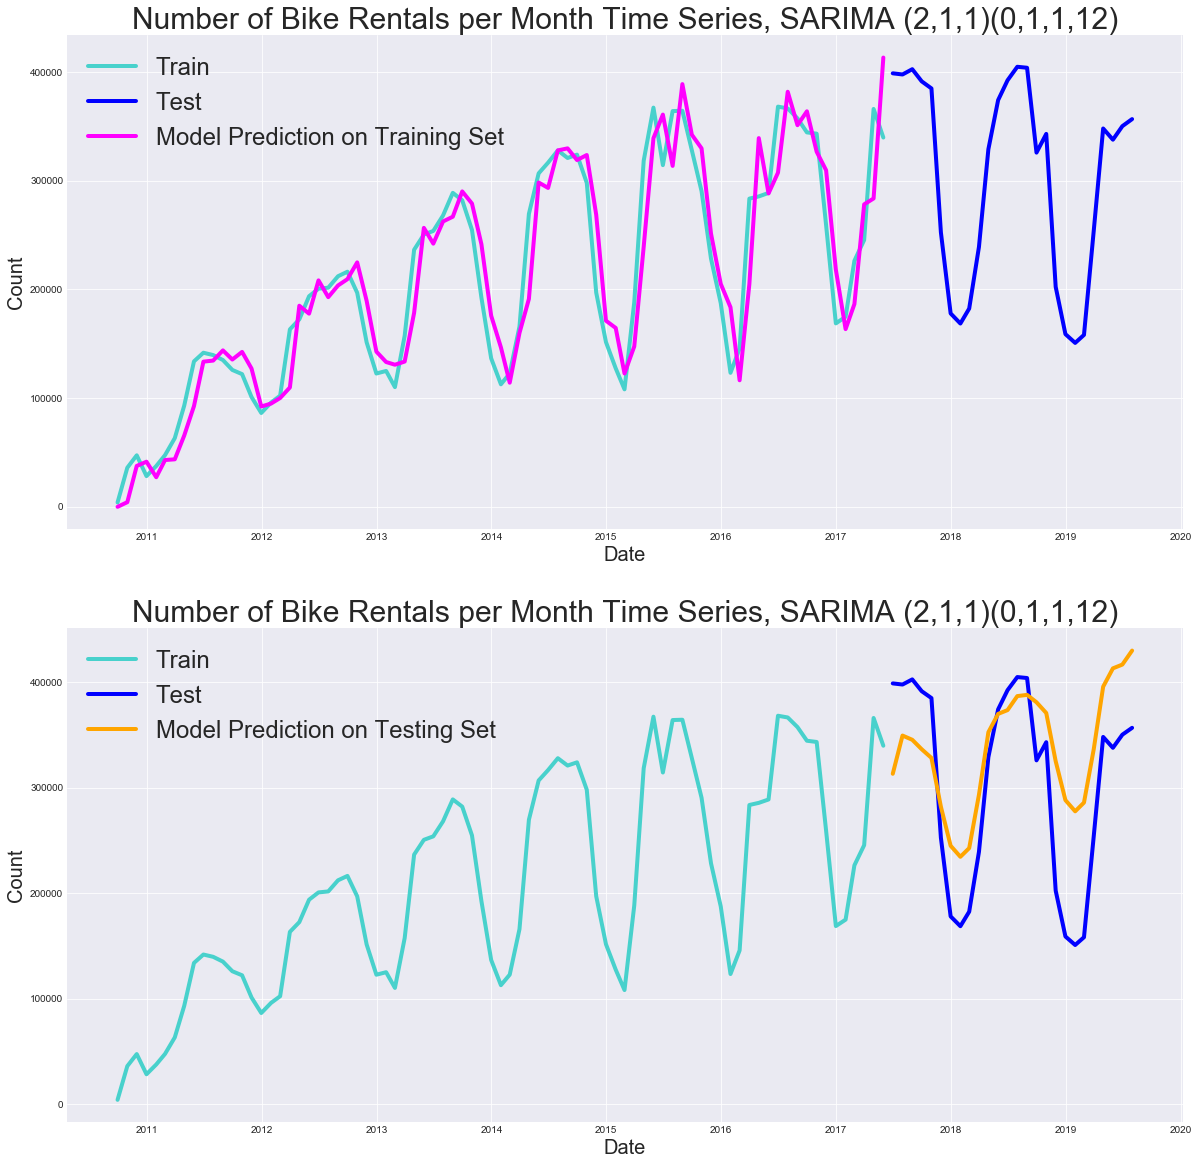

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -799.240
Date:                            Fri, 13 Sep 2019   AIC                           1608.480
Time:                                    20:48:58   BIC                           1619.578
Sample:                                09-30-2010   HQIC                          1612.877
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4082      0.080     -5.106      0.000      -0.565      -0.251
ar.L2         -0.9379      0.052   

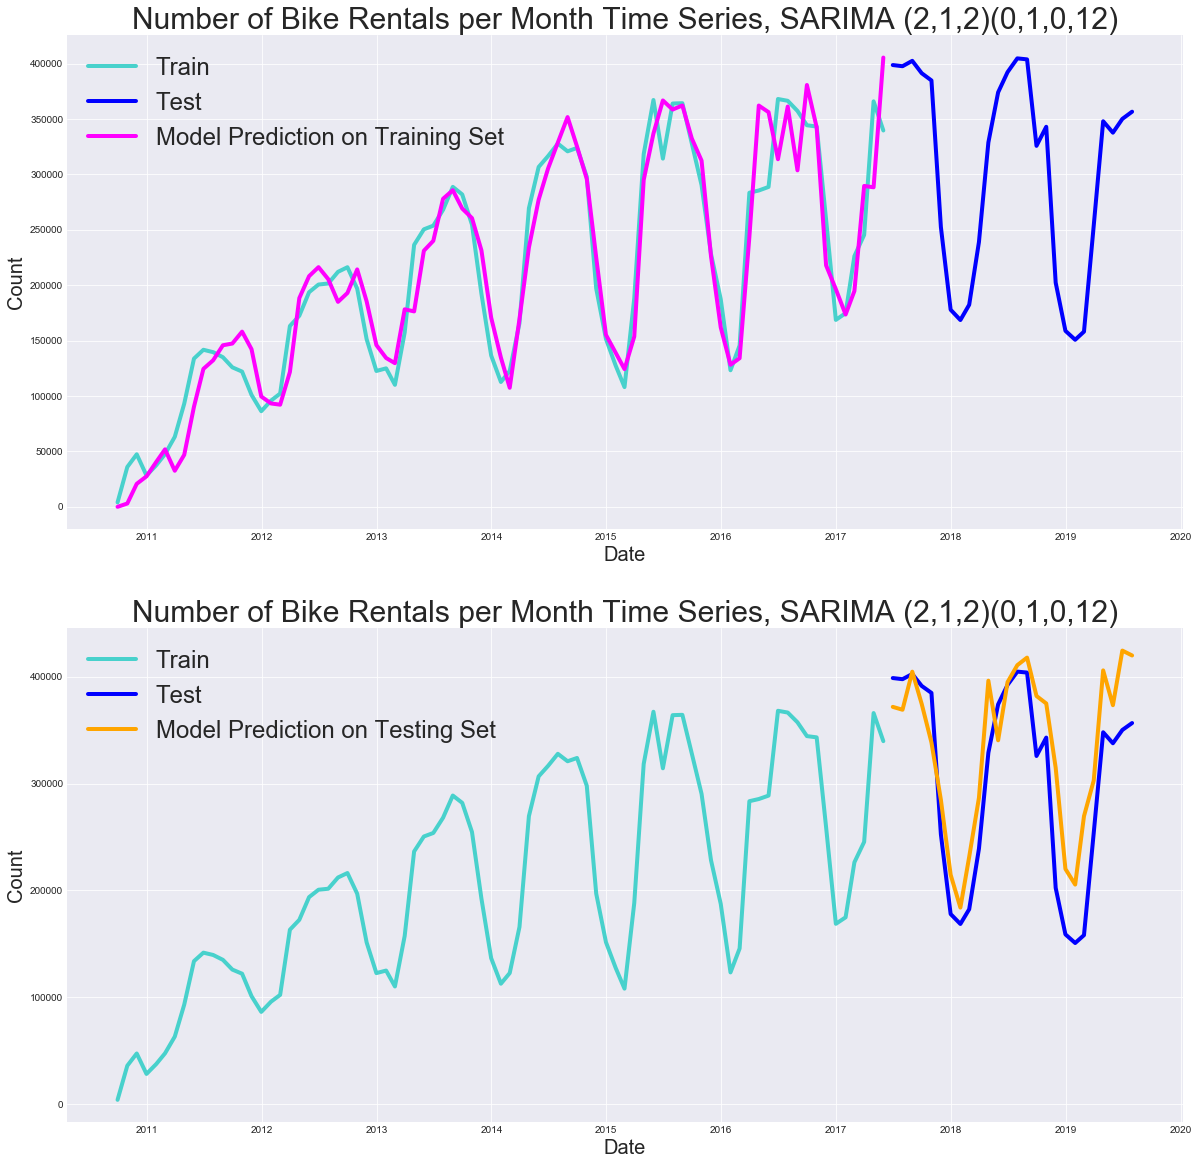

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -799.011
Date:                            Fri, 13 Sep 2019   AIC                           1610.023
Time:                                    20:49:06   BIC                           1623.340
Sample:                                09-30-2010   HQIC                          1615.300
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3795      0.117     -3.252      0.001      -0.608      -0.151
ar.L2         -0.9177      0.065   

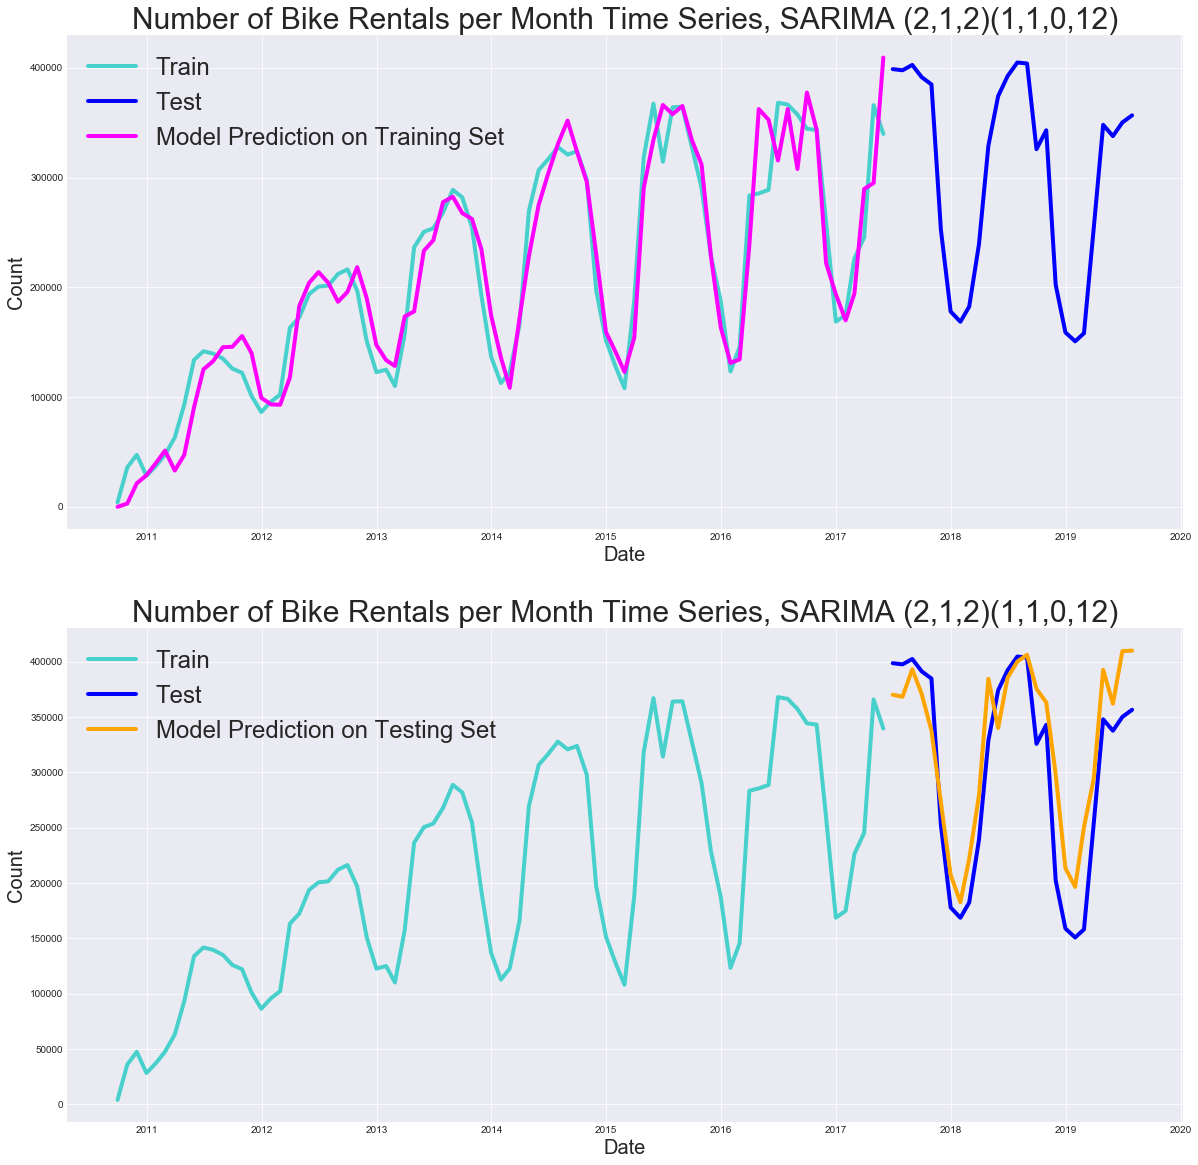

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -802.067
Date:                            Fri, 13 Sep 2019   AIC                           1616.134
Time:                                    20:49:15   BIC                           1629.451
Sample:                                09-30-2010   HQIC                          1621.411
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5021      0.026    -19.221      0.000      -0.553      -0.451
ar.L2         -1.0000      0.040   

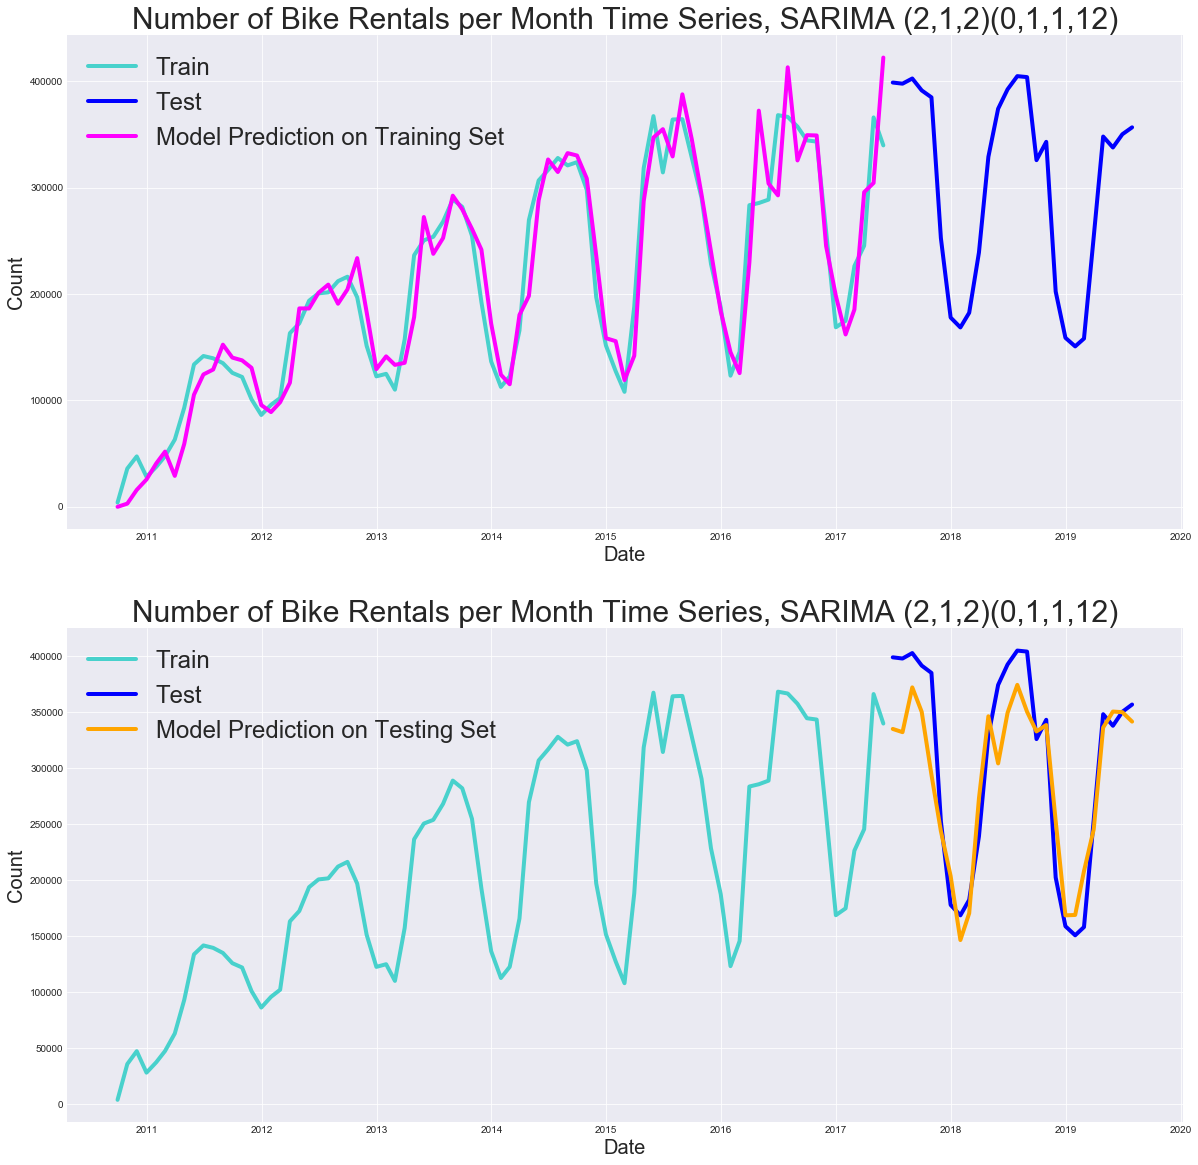

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood                -794.698
Date:                            Fri, 13 Sep 2019   AIC                           1601.396
Time:                                    20:49:22   BIC                           1614.713
Sample:                                09-30-2010   HQIC                          1606.672
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4820      0.034    -14.316      0.000      -0.548      -0.416
ar.L2         -0.9996      0.038   

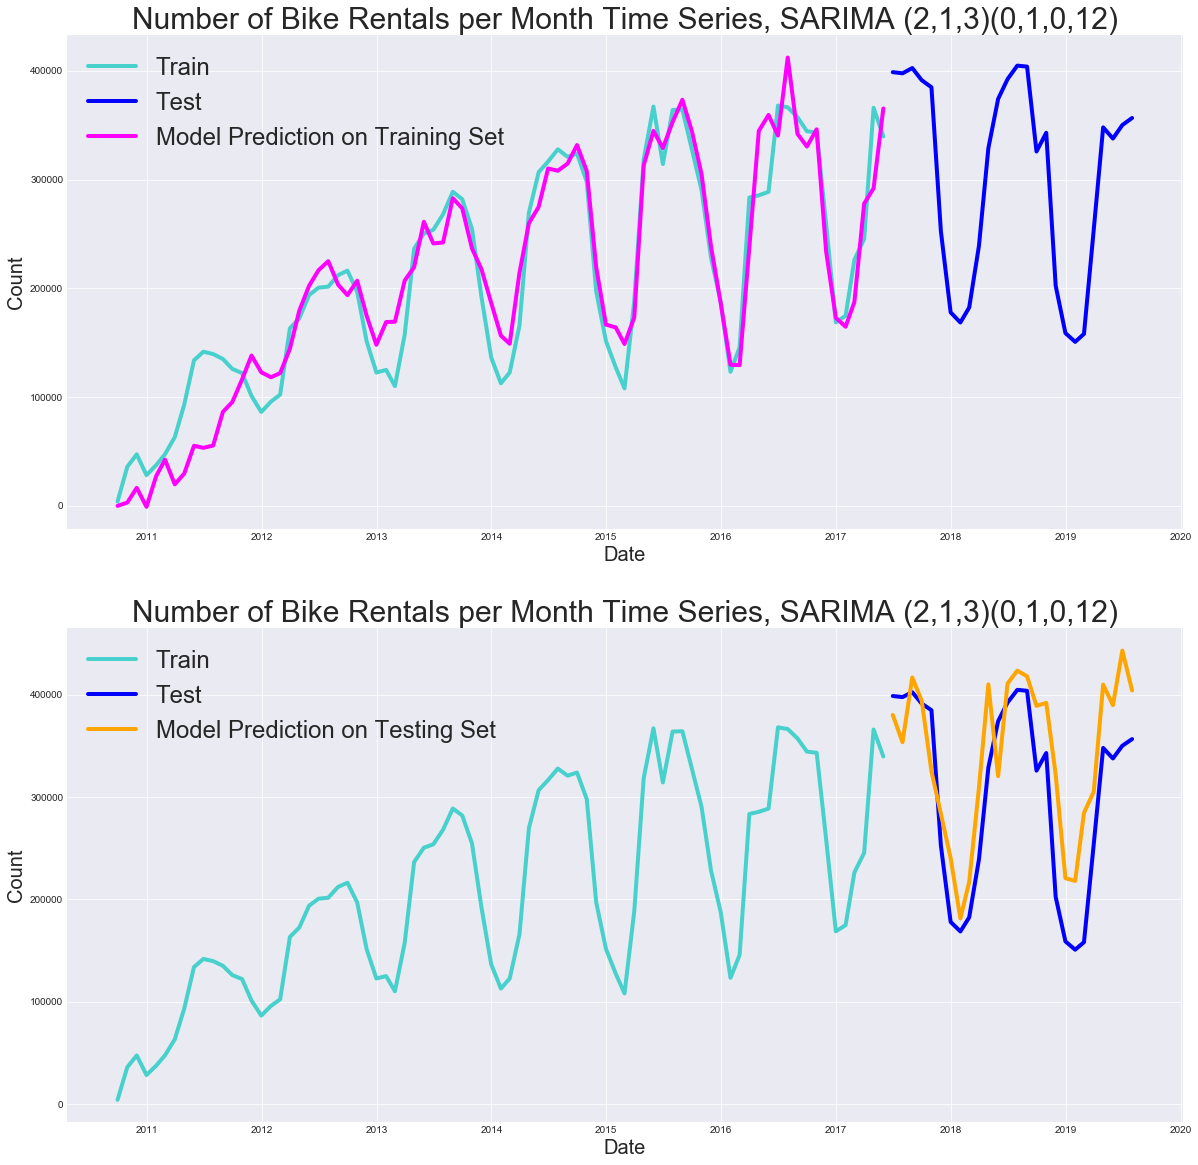

In [ ]:
dt.best_model_sarima(train_df, test_df)

#  Forecast

The (2, 1, 2), (0, 1, 1, 12) model has the lowest MSE for the test data, indicating that this is the model that we should use. Based on this we will create a 12-month forcast of the original dataset, including an 80% prediction interval. 

In [16]:
model_212_01112 = sm.tsa.statespace.SARIMAX(bike_df['count'], trend='n', order=(2, 1, 2),
                                            seasonal_order=(0, 1, 1, 12)).fit()

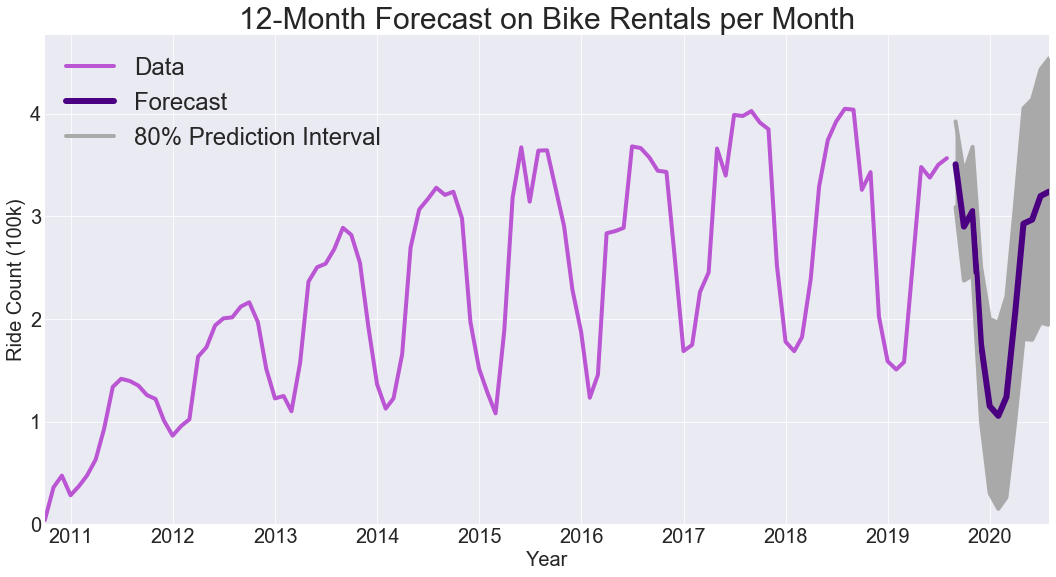

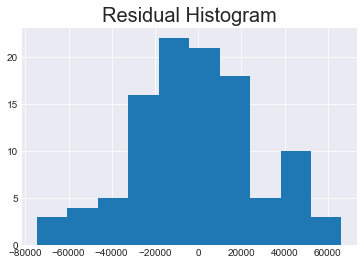

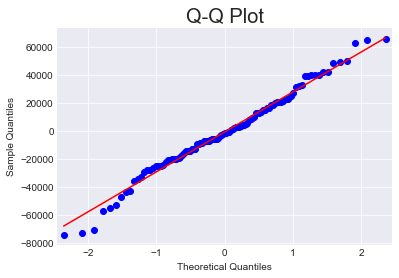

In [29]:
pplot.forecast_plot(model_212_01112, bike_df, n_forecast=12, predict_int_alpha=.2)

From this, we can see that there is still a lot of variance in the prediction interval. One potential step in accounting for this could be membership type. We will now download data grouped by membership, graph it, and split it into the 75%-25% train-test group. We will use the following function to download our dataset that includes membership.

In [17]:
bike_member = f.master_members()

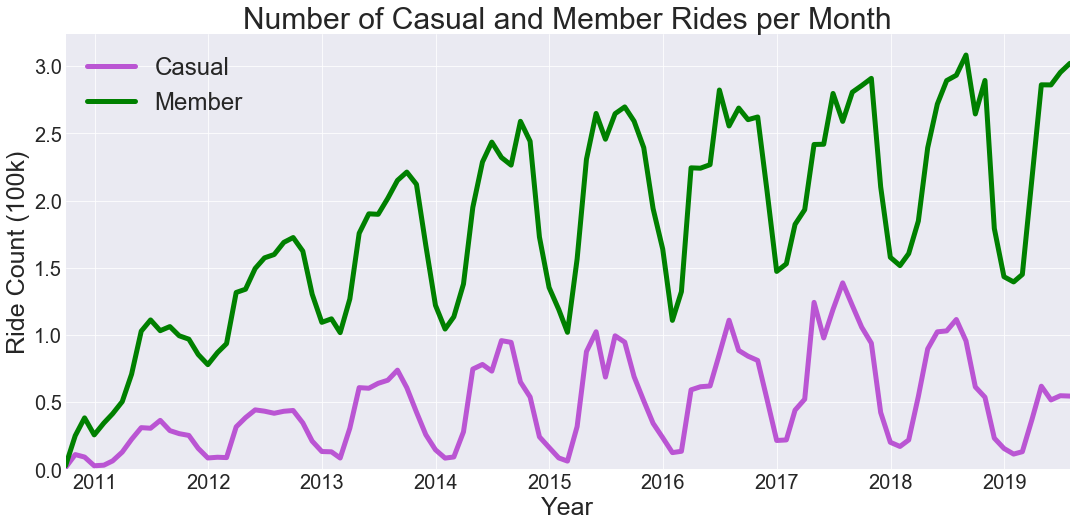

In [18]:
pplot.initial_member_graph(bike_member)

In [19]:
member_train, member_test = f.train_split(bike_member, train_percent=.75)

From this point on, we will divide the data set into 'Members' and 'Casuals', (one-time bicycle renters).

Orders: (2, 1, 0). Seasonal Orders: (0, 1, 0, 12)
                                 Statespace Model Results                                 
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -775.270
Date:                            Fri, 13 Sep 2019   AIC                           1556.540
Time:                                    20:47:39   BIC                           1563.199
Sample:                                09-30-2010   HQIC                          1559.179
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4068      0.079     -5.136      0.000      -0.5

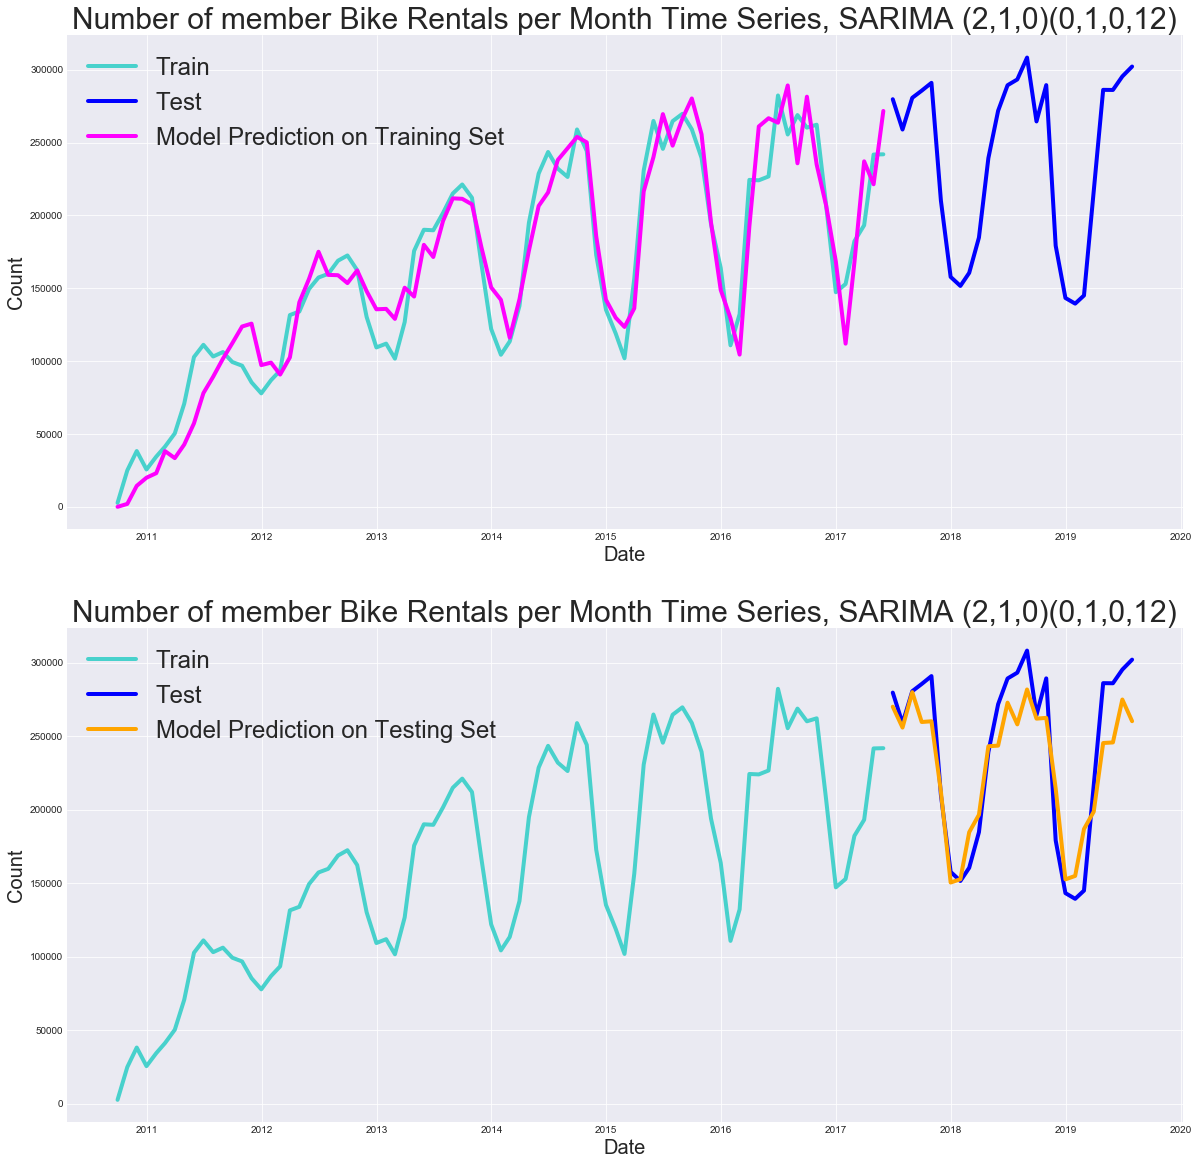

                                 Statespace Model Results                                 
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -748.361
Date:                            Fri, 13 Sep 2019   AIC                           1502.721
Time:                                    20:47:44   BIC                           1509.380
Sample:                                09-30-2010   HQIC                          1505.360
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5329      0.075     -7.103      0.000      -0.680      -0.386
ar.L2         -0.4762      0.112   

NameError: name 'mse' is not defined

In [30]:
dt.sarima_members(member_train, member_test)

We can get good fit for the member data, but the casual use data has a sudden recent dip, which is hard to build a time series model on without more data. We will try with (2,1,3) (0,1,0,12) for Members and (2,1,2)(0,1,1,12) for Casual rides.

In [21]:
members_213_01012 = sm.tsa.statespace.SARIMAX(bike_member['member'], order=(2, 1, 3),
                                              seasonal_order=(0, 1, 0, 12)).fit()
members_213_01012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                  107
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood               -1064.548
Date:                            Fri, 13 Sep 2019   AIC                           2141.095
Time:                                    19:44:29   BIC                           2156.355
Sample:                                09-30-2010   HQIC                          2147.259
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5220      0.037    -14.251      0.000      -0.594      -0.450
ar.L2         -0.9614      0.047    -20.659      0.000      -1.053      -0.870
ma.L1         -0.1973      0.074     -2.672      0.008      -0.342      -0.053
ma.L2          0.4178      0.113      3.691      0.000       0.196       0.640
ma.L3         -0.8414      0.136     -6.206      0.000      -1.107      -0.576
sigma2      4.607e+08   9.25e-11   4.98e+18      0.000    4.61e+08    4.61e+08
===================================================================================
Ljung-Box (Q):                       79.64   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.00   Prob(JB):                         0.72
Heteroskedasticity (H):               1.23   Skew:                             0.06
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+35. Standard errors may be unstable.
"""

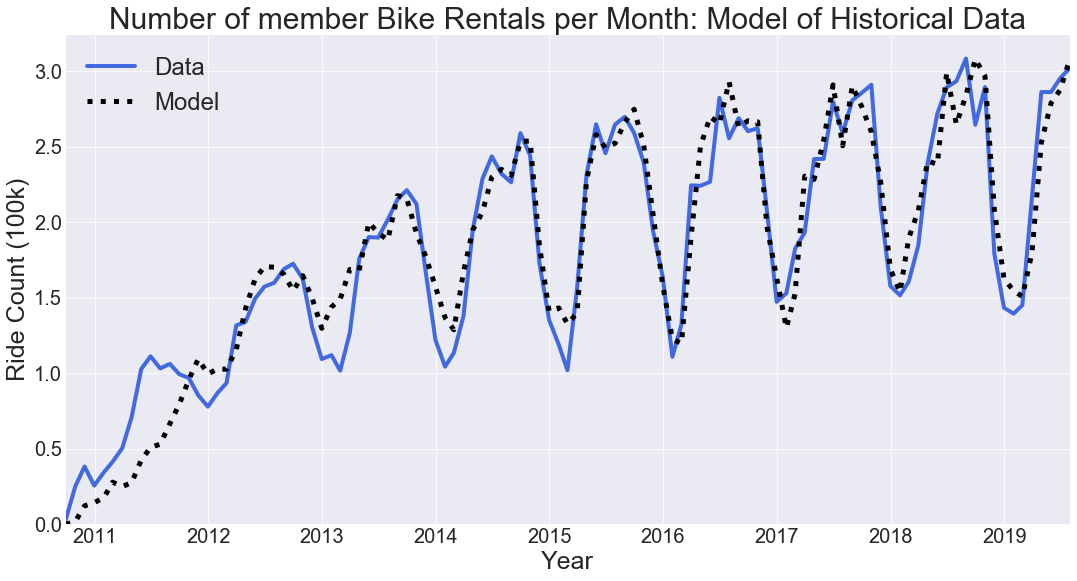

In [22]:
pplot.model_plot_members(members_213_01012, bike_member, kind = 'member')

In [24]:
casual_212_01112 = sm.tsa.statespace.SARIMAX(bike_member['casual'], order=(2, 1, 2),
                                             seasonal_order=(0, 1, 1, 12)).fit()
casual_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             casual   No. Observations:                  107
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1029.449
Date:                            Fri, 13 Sep 2019   AIC                           2070.898
Time:                                    19:44:55   BIC                           2086.158
Sample:                                09-30-2010   HQIC                          2077.062
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3905      0.184      2.118      0.034       0.029       0.752
ar.L2         -0.6174      0.204     -3.033      0.002      -1.016      -0.218
ma.L1         -0.6917      0.131     -5.279      0.000      -0.949      -0.435
ma.L2          0.8461      0.134      6.328      0.000       0.584       1.108
ma.S.L12      -0.5175      0.120     -4.313      0.000      -0.753      -0.282
sigma2       2.47e+08    3.9e-10   6.33e+17      0.000    2.47e+08    2.47e+08
===================================================================================
Ljung-Box (Q):                       45.66   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.25   Prob(JB):                         0.19
Heteroskedasticity (H):               2.15   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+33. Standard errors may be unstable.
"""

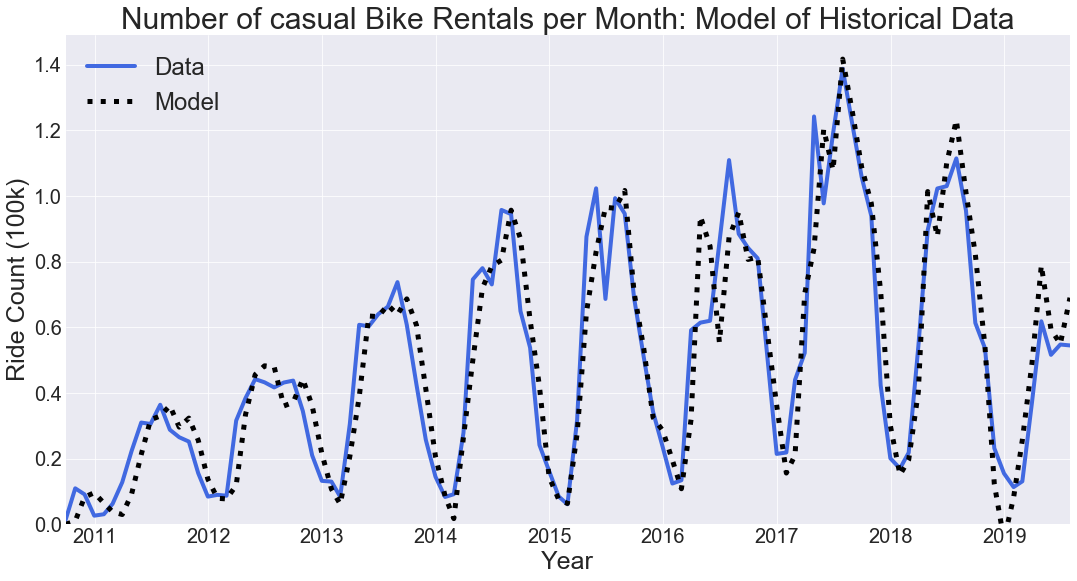

In [25]:
pplot.model_plot_members(casual_212_01112, bike_member, kind='casual')

As you can see, the p-values of both are very low, indicating a close correlation between the models and the actual data. In addition, we can see a very clear difference in volume that members use the bikes, and the volume at which the casual riders use them. 

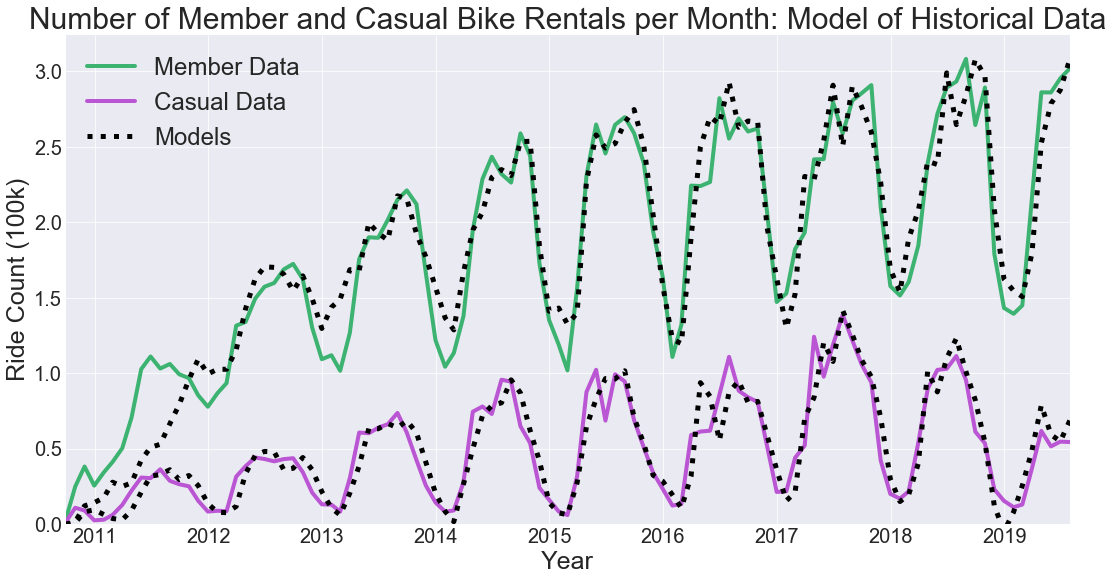

In [26]:
pplot.model_plot_members_both(members_213_01012, casual_212_01112, bike_member)

Now, we will conduct forecasts for both datasets.

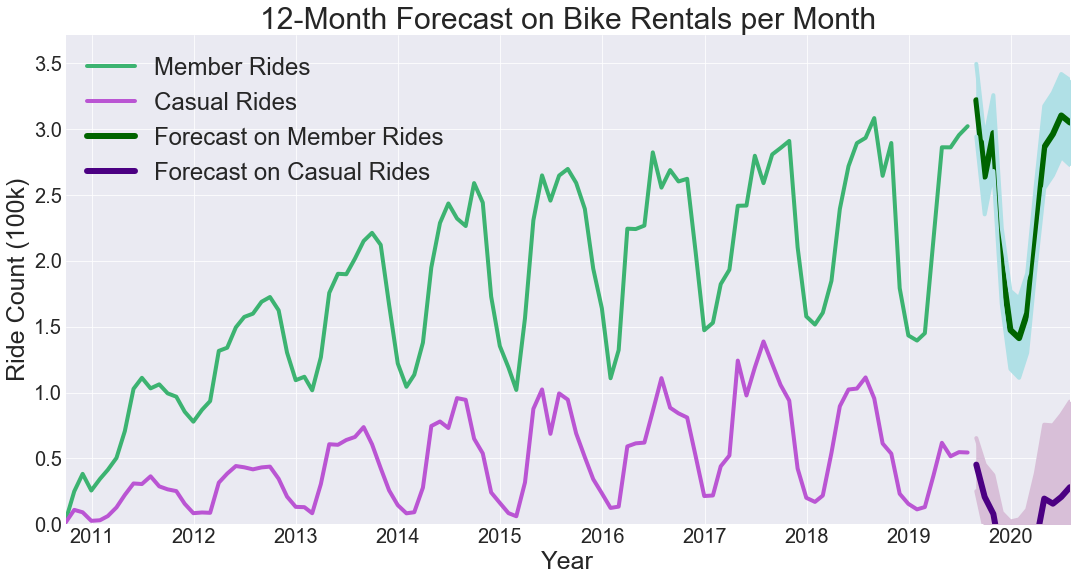

In [27]:
pplot.forecast_plot_members_both(
    members_213_01012, casual_212_01112, bike_member, 12)

As we can see, the size of the prediction interval shrinks for the members, and the prediction shows a leveling out. This indicates that the while the usage isn't increasing for members, it probably isn't decreasing either. However, for the casual riders, we see that the predicted usage drops below zero. This is an indicator that the timeseries, as it is, is still too random to provide stable predictions for this part of the data set.

Based on this prediction, since bicycle use will probably not increase in the next year, we can determine that the Capital Bikeshare has sufficient bicycles to sufficiently operate.